# Language Models

This notebook explores using character-level n-grams to model language. We will learn how to train models by analyzing a body of text, and then use them for a fun task: generating new language in the style of a model.

A brief review of Python strings: recall that strings are sequence-objects. This means that they behave like tuples: they support indexing/slicing and can be iterated over (which occurs character-by-character). Naturally, the length of a string reflects the number of characters in a string. Special characters, like the line-break `\n`, is a single character.

Python provides excellent, efficient string-methods. Initialize some string, `x = "moo"`. And then use tab-completing (`x.<tab>`) to view the list of built-in string methods. Be sure to make use of these whenever appropriate.
Here are a couple of useful resources for working with strings:

- [Basic tutorial for working with strings](https://docs.python.org/3/tutorial/introduction.html#strings)
- [List of string methods](https://docs.python.org/3/library/stdtypes.html#string-methods) (It is a good idea to have this page open in a separate window; we will be making frequent use of the various string methods!)

In [1]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

We will need to make use of this `unzip` function. Try playing with this function to help build your intuition for it.

In [2]:
def unzip(pairs):
    """
    "unzips" of groups of items into separate tuples.
    
    Example: pairs = [("a", 1), ("b", 2), ...] --> (("a", "b", ...), (1, 2, ...))
    
    Parameters
    ----------
    pairs : Iterable[Tuple[Any, ...]]
        An iterable of the form ((a0, b0, c0, ...), (a1, b1, c1, ...))
    
    Returns
    -------
    Tuple[Tuples[Any, ...], ...]
       A tuple containing the "unzipped" contents of `pairs`; i.e. 
       ((a0, a1, ...), (b0, b1, ...), (c0, c1), ...)
    """
    return tuple(zip(*pairs))

## Section 1: Most frequent letters (in English)

Ever wonder why the bonus round of Wheel of Fortune automatically gives the contestant the letters R, S, T, L, N, and E (before letting them choose an additional 3 consonants and 1 vowel)? Or wonder why the letters J, X, Q, and Z are worth so much in Scrabble?

Let's find out by analyzing a particular corpus of English text: Wikipedia. Thanks to Evan Jones for providing a clean text-only version of top Wikipedia articles (based on the Wikipedia "release version" project): http://www.evanjones.ca/software/wikipedia2text.html

Load the entire contents of "wikipedia2text-extracted.txt" into a single string. Because some of these articles contain non-[ASCII](http://www.asciitable.com/) characters (for instance, some Chinese characters), you will need to open the file in binary-read mode: `mode='rb'`. Instead of reading in a typical string, this will read in a `bytes` object, which is simply your machine's memory-encoding for the characters. To make a long story short, you can simply call the method `decode` on this bytes-instance to decode the bytes into a familiar string. E.g. 

```python
with open(path_to_wikipedia, "rb") as f:
    # decoding the bytes into a string
    wikipedia = f.read().decode()
```
After decoding from bytes to a string, **make all of the characters in the string lowercase** (you do not need a for-loop for this!)

Confirm that there are over 63 million characters total, in the string. 

In [3]:
from cogworks_data.language import get_data_path

path_to_wikipedia = get_data_path("wikipedia2text-extracted.txt")

with open(path_to_wikipedia, "rb") as f:
    wikipedia = f.read().decode() # read in and decode the file
    wikipedia = wikipedia.lower() # make all the characters lowercase

# print out the number of characters in `wikipedia
# STUDENT CODE HERE
print(len(wikipedia))

63591333


Print out the first 500 characters of text.

In [4]:
# STUDENT CODE HERE
print(wikipedia[:500])





propaganda is a concerted set of messages aimed at influencing the opinions or behavior of large numbers of people. instead of impartially providing information, propaganda in its most basic sense presents information in order to influence its audience. the most effective propaganda is often completely truthful, but some propaganda presents facts selectively to encourage a particular synthesis, or gives loaded messages in order to produce an emotional rather than rational response to the


### 1.1 Count letters in text

We want to count the occurence of every letter-character in our corpus. First, count up the occurence of every character (including punctuation and special characters, like `\n`).

Hint: Python has a `Counter` object in its `collections` module. You should be able to produce the count for every character in the file in one line. This should take roughly 5 seconds. Using a for-loop will take roughly 10x longer!


In [5]:
from collections import Counter
counter = Counter(wikipedia) #

Now we want a list of character-count tuples sorted in descending order of count. However, we want to filter out all of the non-letter characters. Thus our list should have a length of 26 (since we cast all of the letters to be lower-case):

```
[('e', 6091134),
 ('t', 4456786),
 ('a', 4365050),
 ('i', 3866921),
 ('n', 3740382),
 ('o', 3676394),
 ...
 ```

Note that a simple way to access all lowercase letters in the English alphabet, other than typing out each character manually, is:

```python
>>> import string
>>> string.ascii_lowercase
'abcdefghijklmnopqrstuvwxyz'
```

If you made use of the `Counter` class, then there is a nice instance-method that you can make use of that takes care of sorting the character-count tuples so that the most-common occurences come first. You will need to filter out the non-letter characters.

In [6]:
import string
set_of_letters = string.ascii_lowercase #

# create a sorted list of tuples -- (char, count) -- sorted in descending count-order
char_count_tuples = [(char, count) for (char, count) in counter.most_common() if char in set_of_letters]

print(char_count_tuples)

[('e', 6091134), ('t', 4456786), ('a', 4365050), ('i', 3866921), ('n', 3740382), ('o', 3676394), ('s', 3390251), ('r', 3309159), ('h', 2368877), ('l', 2137466), ('d', 1927612), ('c', 1761449), ('u', 1367019), ('m', 1329206), ('f', 1131994), ('p', 1068764), ('g', 968743), ('y', 787683), ('w', 765023), ('b', 756941), ('v', 541205), ('k', 293580), ('x', 106384), ('j', 90804), ('z', 66251), ('q', 52581)]


Create a variable called `freqs`, which is also a list of tuples, but instead containing character-count pairs, it contains character-frequency pairs. **Frequency is the ratio of the letter-count to the total number of letters (not characters) in the corpus**. It should end up looking something like:

    [('e', 0.12081350306248849),
     ('t', 0.088397321263964282),
     ('a', 0.0865778000521603),
     ...
     ('q', 0.0010429083984244488)]
     
You should **not** iterate over the entire corpus to get the total letter count.

In [7]:
total_count = np.sum(np.array(unzip(char_count_tuples)[1])) #
freqs = [(char, count/total_count) for (char, count) in char_count_tuples] #

print(freqs)

[('e', 0.12081350306248849), ('t', 0.08839732126396428), ('a', 0.0865778000521603), ('i', 0.07669774988957738), ('n', 0.07418793482656542), ('o', 0.0729187763358866), ('s', 0.06724332440742638), ('r', 0.06563491970144826), ('h', 0.046985065292301655), ('l', 0.042395185385342864), ('d', 0.03823287392221047), ('c', 0.034937143749573935), ('u', 0.027113892773165053), ('m', 0.0263638976176978), ('f', 0.022452331632454414), ('p', 0.02119820755660234), ('g', 0.019214359000682676), ('y', 0.015623156957763548), ('w', 0.01517371125858898), ('b', 0.015013410281504741), ('v', 0.010734433346062338), ('k', 0.005822959768917474), ('x', 0.002110054336318947), ('j', 0.0018010356252359913), ('z', 0.0013140435576352325), ('q', 0.0010429083984244488)]


Confirm that the frequencies total to 1 (within numerical precision).

In [8]:
# STUDENT CODE HERE
print(np.sum(np.array(unzip(freqs)[1])))

1.0


### 1.2 Plot letter frequency histogram

Using 
```
fig, ax = plt.subplots()

ax.bar(characters, frequencies, align='center', alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Letters in English')
```
Look up the documentation for `ax.bar` (use shift-tab in your Jupyter notebook!) to plot a bar-graph of the characters and their frequencies. The x-axis should order the characters in decreasing frequency.

Be sure to provide a title and a descriptive label for the y-axis.

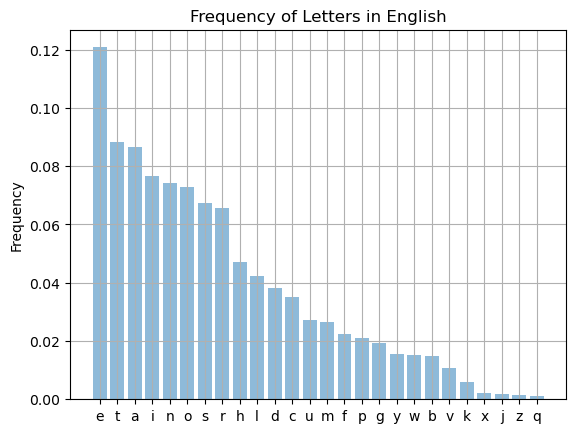

In [9]:
# STUDENT CODE HERE
fig, ax = plt.subplots()

ax.bar(unzip(freqs)[0], unzip(freqs)[1], align='center', alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Letters in English')

ax.grid()

## Section 2: Most frequent words (in English)

Let's move up a level from characters and look at the distribution the English words. Returning to the full wikipedia corpus, which we have stored as a lower-cased string. Let's tokenize the corpus: separating the string into individual words.

### 2.1 (Simple) Tokenization

For now we'll just apply a simple tokenization scheme: splitting our string on any whitespace (spaces, tabs, newlines, etc.) characters.

Without using a for-loop, produce a list of the "tokens" from the corpus, and print out the first 10 tokens along with the total number of tokens.

In [12]:
# STUDENT CODE HERE
tokens = wikipedia.split()
print(tokens[:10])

['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


As you did above with characters, count the occurences of all of the different words. 

In [14]:
# word -> count
word_counts = len(tokens)#
print(word_counts)

10124357


Finally, display the top 20 most-common words and their associated occurences.

In [16]:
# STUDENT CODE HERE
print(Counter(tokens).most_common()[:20])

[('the', 782374), ('of', 403206), ('and', 307101), ('in', 268422), ('to', 224263), ('a', 197485), ('is', 107398), ('as', 96039), ('was', 91048), ('by', 76790), ('for', 74871), ('that', 73001), ('with', 68155), ('on', 63819), ('from', 52317), ('are', 51441), ('his', 45043), ('it', 42324), ('at', 39468), ('an', 38318)]


What do you notice about this list? Do you see any people, places, or other distinguishing words in towards the top of this list? Can you discern anything about the content of the articles from these words (other than the fact that they predominantly contain English)? 

These abundant "glue" words, **referred to as "stop words" in NLP applications**, are ubiquitous to modern English. They provide the necessary glue needed for a coherent grammar, but do not provide actual meaning to text. Often, we will want to filter them out, so that we can get at the "meaningful" words in a corpus.

See https://en.wikipedia.org/wiki/Stop_words for more details. 

## 3 Creating an n-gram language model

An **n-gram** is a contiguous sequence of n characters from a piece of text.
For example `"cat in"` is a $6$-gram, `"th"` is a $2$-gram, etc..

Inspired by Yoav Goldberg blog, which in turn was inspired by a [post from Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) that you saw in the Perspective on Machine Learning module, we will train our own n-gram language model.

**Character-based n-gram language models aim to guess the next letter based on seeing the previous (n-1) letters.** (The assumption that the probability of seeing a letter only depends on a certain finite number of previous letters is an example of a Markov assumption. See https://en.wikipedia.org/wiki/Markov_property for more information.)

Just as we did above, we will want to take a counter of `letter -> count` pairs, and convert them to `letter -> frequency` pairs. Using your code from earlier as reference, provide the body for the following function. Do **not** filter any characters this time.

In [20]:
def normalize(counter):
    """ Convert a `letter -> count` counter to a list 
    of (letter, frequency) pairs, sorted in descending order of 
    frequency.

    Parameters
    -----------
    counter : collections.Counter
        letter -> count

    Returns
    -------
    List[Tuple[str, float]]
       A list of tuples: (letter, frequency) pairs in order
       of descending-frequency

    Examples
    --------
    >>> from collections import Counter
    >>> letter_count = Counter({"a": 1, "b": 3})
    >>> letter_count
    Counter({'a': 1, 'b': 3})

    >>> normalize(letter_count)
    [('b', 0.75), ('a', 0.25)]
    """
    # STUDENT CODE HERE
    counters = counter.most_common()
    total_count = sum(unzip(counters)[1])
    return [(char, count/total_count) for (char, count) in counters]

In the following, we will want to make some serious use of Python's `collections` module. Not only do we want to use the `Counter` class again, we also will want to use a [defaultdict](http://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/DataStructures_III_Sets_and_More.html#Default-Dictionary). 

Now we'll create the function to actually analyze the n-grams (a length-n sequence of characters) that occur in a text:
 - For each distinct sequence of n-1 characters, we will keep a tally of the character that follows that sequence.
 - After counting is done, we'll normalize the char_count_tuples for each history to convert to frequencies, which we can interpret as probabilities.
 - At the beginning of a document we'll pad the text with a dummy character, "~". We will pre-pend $n-1$ of these to the beginning of our text.

Our "model" simply keeps track of all length-(n-1) histories in a given text and the associated tallies of the various characters that follow each history.

Thus our model can be thought of as two nested dictionaries:  

```
model: {(n-1) character history -> {nth-letter -> count}}
```

Here's an illustration of the process for analyzing the text "cacao" in terms of 3-grams:

    history is "~~", next char is "c", increment model["~~"]["c"]
    history is "~c", next char is "a", increment model["~c"]["a"]
    history is "ca", next char is "c", increment model["ca"]["c"]
    history is "ac", next char is "a", increment model["ac"]["a"]
    history is "ca", next char is "o", increment model["ca"]["o"]
    history is "ao", next char does not exists. End process


Here's an illustration of the process for analyzing the text "cacao" in terms of 4-grams:

    history is "~~~", next char is "c", increment model["~~~"]["c"]
    history is "~~c", next char is "a", increment model["~~c"]["a"]
    history is "~ca", next char is "c", increment model["~ca"]["c"]
    history is "cac", next char is "a", increment model["cac"]["a"]
    history is "aca", next char is "o", increment model["aca"]["o"]
    history is "cao", next char does not exists. End process
    


So we will want to our model to be a default dictionary, whose default value is an empty `Counter` instance. Thus any time we encounter a new history, our model will create an empty counter for that history.

I.e. `model = defaultdict(Counter)`. Thus `model[history]` will return the counter for that history. You can then update that counter with the character that comes after that history: `model[history][char] += 1`

To "train" our language model is to simply populate its counters for all of the histories in a given text. Complete the following `train_lm` function

In [22]:
from collections import defaultdict

def train_lm(text, n):
    """ Train character-based n-gram language model.
        
    This will learn: given a sequence of n-1 characters, what the probability
    distribution is for the n-th character in the sequence.

    For example if we train on the text:
        text = "cacao"

    Using a n-gram size of n=3, then the following dict would be returned.
    See that we *normalize* each of the char_count_tuples for a given history

        {'ac': [('a', 1.0)],
         'ca': [('c', 0.5), ('o', 0.5)],
         '~c': [('a', 1.0)],
         '~~': [('c', 1.0)]}

    Tildas ("~") are used for padding the history when necessary, so that it's 
    possible to estimate the probability of a seeing a character when there 
    aren't (n - 1) previous characters of history available.

    So, according to this text we trained on, if you see the sequence 'ac',
    our model predicts that the next character should be 'a' 100% of the time.

    For generating the padding, recall that Python allows you to generate 
    repeated sequences easily: 
       `"p" * 4` returns `"pppp"`

    Parameters
    -----------
    text: str 
        A string (doesn't need to be lowercased).
        
    n: int
        The length of n-gram to analyze.

    Returns
    -------
    Dict[str, List[Tuple[str, float]]]
        
        {n-1 history -> [(letter, normalized count), ...]}
        
        A dictionary that maps histories (strings of length (n-1)) to lists of (char, prob) 
        pairs, where prob is the probability (i.e frequency) of char appearing after 
        that specific history.

    Examples
    --------
    >>> train_lm("cacao", 3)
    {'ac': [('a', 1.0)],
     'ca': [('c', 0.5), ('o', 0.5)],
     '~c': [('a', 1.0)],
     '~~': [('c', 1.0)]}
    """

    raw_lm = defaultdict(Counter) # history -> {char -> count}
    history = '~'*(n - 1) # length n - 1 history
    
    # count number of times characters appear following different histories
    #
    # for char in text ...
    #    1. Increment language model's count, given current history and character
    #    2. Update history

    # STUDENT CODE HERE
    for char in text:
        raw_lm[history][char] += 1
        history = history[1:] + char
    # create the finalized language model – a dictionary with: history -> [(char, freq), ...]
    lm = {history : normalize(counter) for history, counter in raw_lm.items()}#
    
    return lm


Test train_lm() on "cacao", using n=3. You should get the same result as in the docstring.

In [31]:
# STUDENT CODE HERE
lm3 = train_lm("cacao", 3)
lm3

{'~~': [('c', 1.0)],
 '~c': [('a', 1.0)],
 'ca': [('c', 0.5), ('o', 0.5)],
 'ac': [('a', 1.0)]}

Now let's test our function on more serious example: a small snippet of text from "The Cat in the Hat" by Dr. Seuss.

In [32]:
text = """The sun did not shine, it was too wet to play, 
so we sat in the house all that cold, cold wet day. 
I sat there with Sally. We sat here we two 
and we said 'How we wish we had something to do.'"""

In [33]:
# STUDENT CODE HERE
lm3 = train_lm(text, 3)
lm3

{'~~': [('T', 1.0)],
 '~T': [('h', 1.0)],
 'Th': [('e', 1.0)],
 'he': [(' ', 0.5), ('r', 0.5)],
 'e ': [('s', 0.36363636363636365),
  ('w', 0.2727272727272727),
  ('h', 0.18181818181818182),
  ('a', 0.09090909090909091),
  ('t', 0.09090909090909091)],
 ' s': [('a', 0.5714285714285714),
  ('u', 0.14285714285714285),
  ('h', 0.14285714285714285),
  ('o', 0.14285714285714285)],
 'su': [('n', 1.0)],
 'un': [(' ', 1.0)],
 'n ': [('d', 0.5), ('t', 0.5)],
 ' d': [('i', 0.3333333333333333),
  ('a', 0.3333333333333333),
  ('o', 0.3333333333333333)],
 'di': [('d', 1.0)],
 'id': [(' ', 1.0)],
 'd ': [('w', 0.4), ('n', 0.2), ("'", 0.2), ('s', 0.2)],
 ' n': [('o', 1.0)],
 'no': [('t', 1.0)],
 'ot': [(' ', 1.0)],
 't ': [('t', 0.25),
  ('s', 0.125),
  ('w', 0.125),
  ('i', 0.125),
  ('c', 0.125),
  ('d', 0.125),
  ('h', 0.125)],
 'sh': [('i', 0.5), (' ', 0.5)],
 'hi': [('n', 1.0)],
 'in': [('e', 0.3333333333333333),
  (' ', 0.3333333333333333),
  ('g', 0.3333333333333333)],
 'ne': [(',', 1.0)],
 'e,

The following should show a probability of 1.0 for the letter "T", since that's the only starting letter that the model has ever seen (i.e., with no history, indicated by "~~").

In [34]:
lm3["~~"]

[('T', 1.0)]

Similarly, the following should show a probability of 1.0 for "h", since that's the only letter the model has seen after a history of "~T".

In [35]:
lm3["~T"]

[('h', 1.0)]

This last example should give a probability distribution of the characters "e", "a", " ", and "i", since those four characters all were observed to follow "th" in the text (with "e" occurring most often).

In [36]:
lm3["th"]

[('e', 0.4), ('a', 0.2), (' ', 0.2), ('i', 0.2)]

## 4 Generating text

A fun thing to do with language models is to generate random text in the style of the model by generating letters using the learned probability distributions. 

First we'll create a function to randomly draw a single letter given a particular history, based on the probabilities stored in our language model.

Hint: `np.random.choice(choices, p=probabilities)` will return an element from choices according to the specified probabilities. For example, `np.random.choice(["a", "b"], [0.25, 0.75])` will return an "a" 25% of the time and a "b" 75% of the time.

Complete the following function. You will want to make use of the `unzip` function defined above to perform the following:


```[(char0, prob0), (char1, prob1), ...] -> ((char0, char1, ...), (prob0, prob1, ...))```

In [40]:
def generate_letter(lm, history):
    """ Randomly picks letter according to probability distribution associated with 
    the specified history, as stored in your language model.

    Note: returns dummy character "~" if history not found in model.

    Parameters
    ----------
    lm: Dict[str, List[Tuple[str, float]]] 
        The n-gram language model. 
        I.e. the dictionary: history -> [(char, freq), ...]

    history: str
        A string of length (n-1) to use as context/history for generating 
        the next character.

    Returns
    -------
    str
        The predicted character. '~' if history is not in language model.
    """
    # STUDENT CODE HERE
    if not history in lm:
        return "~"
    letters, probs = unzip(lm[history])
    i = np.random.choice(letters, p=probs)
    return i

The following should generate "e", "a", " ", or "i", since those are the only four characters that followed "th".

In [41]:
# draw from `generate_letter` 100 times, keep only the unique outcomes
set(generate_letter(lm3, "th") for i in range(100))

{' ', 'a', 'e', 'i'}

The following generates several possible next characters to get a sense of the distribution. "e" should appear more frequently than the other characters on average since it has a higher probability of following "th".

In [42]:
[generate_letter(lm3, "th") for i in range(10)]

[' ', ' ', 'e', ' ', 'e', ' ', 'e', 'a', 'e', ' ']

Finally, we'll generate whole sequences of text according to the language model. The approach will be to start with no history, i.e. $n - 1$ `~`'s, generate a random letter, update the history, and repeat. In our example,

    history "~~" will generate 'T' (since only one possibility)
    history "~T" will generate 'h' (since only one possibility)
    history "Th" will generate 'e' (since only one possibility)
    history "he" could generate 'r' (out of multiple possibilities)
    history "er" will generate 'e' (since only one possibility)

and so on. The text generated so far would be "There".

In [43]:
def generate_text(lm, n, nletters=100):
    """ Randomly generates `nletters` of text by drawing from 
    the probability distributions stored in a n-gram language model 
    `lm`.

    Parameters
    ----------
    lm: Dict[str, List[Tuple[str, float]]]
        The n-gram language model. 
        I.e. the dictionary: history -> [(char, freq), ...]
    
    n: int
        Order of n-gram model.
    
    nletters: int
        Number of letters to randomly generate.

    Returns
    -------
    str
        Model-generated text. Should contain `nletters` number of
        generated characters. The pre-pended ~'s are not to be included. 
    """
    # STUDENT CODE HERE
    history = "~" * (n - 1)
    text = []
    for i in range(nletters):
        c = generate_letter(lm, history)
        text.append(c)
        history = history[1:] + c
    return "".join(text) 

The following will generate 40 characters according to the 3-gram language model trained on the beginning of "The Cat in the Hat". It won't be very pretty... partly because of the short history length and also the small amount of training data.

In [44]:
print(generate_text(lm3, 3, 40))

There thad wish Sall to we said wethin t


## 5 Generating "Shakespeare"

Lastly, we'll have some fun trying to generate text in the style of Shakespeare.

The next cell loads in Andrej Karpathy's shakespeare_input.txt file.

In [45]:
path_to_shakespeare = get_data_path("shakespeare_input.txt")

with open(path_to_shakespeare, "r") as f:
    shakespeare = f.read()
print(str(len(shakespeare)) + " character(s)")
chars = set(shakespeare)
print(f"'~' is a good pad character: {'~' not in chars}")

4573338 character(s)
'~' is a good pad character: True


Now experiment with training models for various values of n (e.g., 3, 5, and 11) and generate some text (maybe 500 characters or so). You should find the 3-gram model to be a very bad speller; the 5-gram model a better speller, but not making much sense; and the 11-gram model looking pretty good (which is amazing considering the simplicity of the model).

In [46]:
# STUDENT CODE HERE
t0 = time.time()
lm3 = train_lm(shakespeare, 3)
t1 = time.time()
print("elapsed = " + str(t1 - t0) + "s")

elapsed = 0.7838339805603027s


In [47]:
print(generate_text(lm3, 3, 500))

Firtell legaidgescame
sh thaest ofulis as is therither.
The warewl to to lor give kno heir.

HORD I deak ha'ent will tishour, enot the mis fore'tionit;
AN:
And his chut of yorn,
Thou look he welf
th thave ther Clespers; se wasineste Cass sidnes st sess, asubjespers re to a Ric, mand ke sper inst To I she diecoulcom all I'llorme hent of I ke arry, goody hel I ther wil,
Thourse a weave wall bast con youl case
He he here noth worthe ing in se pur tiould flike fria.

Whouse way--

Doct heat Netten t


In [48]:
# STUDENT CODE HERE
t0 = time.time()
lm5 = train_lm(shakespeare, 5)
t1 = time.time()
print("elapsed = " + str(t1 - t0) + "s")

elapsed = 1.8457279205322266s


In [49]:
print(generate_text(lm5, 5, 500))

First Cade!

LEPIDUS:
I'll chain; and of sover well.

CLOTEN:
But sleep. I pray me! the prevailed?

EARL OF EPHESUS:
Thou frowned do resolute them?
I would not unknow it is a
news?

SPEED:
'Item: for I sweet stir; and yet, I this entriving-glass of this faires offerance of fear, to save and I
trust a feodary.

ROSS:
Alack, and from the make unfit for meaning,
Would been this peseech youth's-betrayer to you spy, lords, in the other breed any power,--
Then I am I, old you truments, I take up ye
St


In [50]:
# STUDENT CODE HERE
t0 = time.time()
lm11 = train_lm(shakespeare, 11)
t1 = time.time()
print("elapsed = " + str(t1 - t0) + "s")

elapsed = 9.40654706954956s


In [51]:
print(generate_text(lm11, 11, 500))

First Citizen:
Not one to the Capitol,
Being cross'd in conference with his head, as it were unlicensed of your discords be
That e'er our heads to her, and in thy day of doom.
This ague fit of fear and nothing that sweep away the strength of sickness, for instead of words,
I send thee?

DIOMEDES:
We sympathize,
And with a kind of fruit
Drops earliest to thee,
All that he did beat me these news would cause him once more to come in:
A comfortable words as medicinal gum. Set you down,
And ask him w


Idea for bonus fun: find some other text on the Internet to train models on, e.g., song lyrics, books from a particular author, etc.